### Load Package

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from datetime import datetime 
import math
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from pathlib import Path
# import arviz as az
# import pymc as pm
# import pymc_bart as pmb
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import dgl
import fiona
import networkx as nx
import scipy.sparse as sps

Using backend: pytorch


### Figure settings

In [2]:
rcParams['font.family'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.cal'] = 'Arial'
rcParams['legend.fontsize'] = 'medium'

### Function definition

In [3]:
# define function from str to float
def strlist_coversion_array(string):
    aa = string.split(', ')
    aa[0] = aa[0].split('[')[1]
    aa[-1] = aa[-1].split(']')[0]
    return np.float_(aa)

### Load original boundary and geometry data

#### Read file in Miami-Dade County

In [4]:
# Miami-Dade boundary data
miami_boundary = gpd.read_file('Data/Miami-Dade_Boundary.geojson')

# Road network data within miami-dade county
miami_road_network = gpd.read_file('Data/Major_Road.geojson')
miami_highway_network = gpd.read_file('Data/Highway.geojson')
miami_land_use = gpd.read_file('Data/Land_Use.geojson')

# read census tract data
ct_acs_2020 = gpd.read_file('Data/centract_acs_2020.gdb.geojson')
ct_acs_2020 = ct_acs_2020.set_crs(epsg = 3087, allow_override=True, inplace=True)
ct_acs_2020 = ct_acs_2020.to_crs(epsg = 4326)
miami_ct_acs_2020 = ct_acs_2020[ct_acs_2020['COUNTY'] == 86]

#### Read file for each node/traffic detector with data in Miami-Dade County

In [5]:
# Load zone_id_attribute in miami-dade county
influencing_factor_attribute = pd.read_csv('Excel/Miami_node_attribute_final_final.csv')
influencing_factor_attribute = influencing_factor_attribute.drop(columns = 'geometry')
influencing_factor_attribute['geometry'] = influencing_factor_attribute[['longitude', 'latitude']].values.tolist()
influencing_factor_attribute['geometry'] = influencing_factor_attribute['geometry'].apply(Point)
influencing_factor_attribute = gpd.GeoDataFrame(influencing_factor_attribute)

# adjust TRACTCE10 in influencing_factor_attribute
influencing_factor_attribute.head()

,zone_id,state,road,direction,lane_type,length,LND,latitude,longitude,gw_population_density,...,gw_car_ownership,gw_employment_density,gw_lu_diversity,gw_highway_density,gw_major_road_density,clustering_coefficient,degree_centrality,closeness_centrality,Evac_Route_Index,geometry
0,8715,District 6,I-95,North,Unknown,0.27,4.396292,25.905130,-80.209160,12.805512,...,1.639288,5.788816,1.632445,0.003347,0.011928,0.250000,0.002714,0.002714,0.0,POINT (-80.20916 25.90513)
1,8726,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,1.163839,17.030566,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843)
2,8727,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,1.163839,17.030566,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843)
3,8728,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,1.163839,17.030566,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843)
4,8747,District 6,I-95,North,Unknown,0.37,3.644370,25.914850,-80.210390,12.379203,...,1.643286,5.604295,1.649677,0.003525,0.011763,0.166667,0.004071,0.004342,1.0,POINT (-80.21039 25.91485)


In [6]:
len(influencing_factor_attribute)

738

#### Add default speed

In [7]:
# include all traffic detectors
traffic_detector_inventory = pd.read_csv('Data/Inventory.csv')
influencing_factor_attribute = influencing_factor_attribute.merge(traffic_detector_inventory[['zone_id', 'default_speed']], how = 'left', on = 'zone_id')
influencing_factor_attribute.head()

,zone_id,state,road,direction,lane_type,length,LND,latitude,longitude,gw_population_density,...,gw_employment_density,gw_lu_diversity,gw_highway_density,gw_major_road_density,clustering_coefficient,degree_centrality,closeness_centrality,Evac_Route_Index,geometry,default_speed
0,8715,District 6,I-95,North,Unknown,0.27,4.396292,25.905130,-80.209160,12.805512,...,5.788816,1.632445,0.003347,0.011928,0.250000,0.002714,0.002714,0.0,POINT (-80.20916 25.90513),55.0
1,8726,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,17.030566,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843),55.0
2,8727,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,17.030566,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843),55.0
3,8728,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,17.030566,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843),55.0
4,8747,District 6,I-95,North,Unknown,0.37,3.644370,25.914850,-80.210390,12.379203,...,5.604295,1.649677,0.003525,0.011763,0.166667,0.004071,0.004342,1.0,POINT (-80.21039 25.91485),55.0


#### Add capacity

In [8]:
rc_data = {
    'road': [
        'I-95', 'I-395', 'I-195', 'SR-826', 'SR-924', 'SR-836', 'SR-874',
        'SR-112', 'Central Boulevard', 'SR-878', '95 Express', 'US-1',
        'I-75', '826 Express', 'SR-821', 'Floridas Turnpike', '75 Express'
    ],
    'Estimated Lanes (per direction)': [
        5, 4, 4, 4, 2, 4, 2,
        2, 3, 2, 2, 3,
        5, 2, 3, 4, 2
    ],
    'Estimated Design Capacity (vph per lane)': [
        2200, 2200, 2200, 2000, 2000, 2000, 2000,
        2000, 1800, 2000, 2200, 1800,
        2200, 2200, 2000, 2000, 2200
    ]
}

# Calculate total design capacity per direction
rc_data['Capacity (v/5min)'] = [
    lanes * capacity / 6 for lanes, capacity in zip(rc_data['Estimated Lanes (per direction)'], rc_data['Estimated Design Capacity (vph per lane)'])
]

rc_data = pd.DataFrame(rc_data)
rc_data.head()

,road,Estimated Lanes (per direction),Estimated Design Capacity (vph per lane),Capacity (v/5min)
0,I-95,5,2200,1833.333333
1,I-395,4,2200,1466.666667
2,I-195,4,2200,1466.666667
3,SR-826,4,2000,1333.333333
4,SR-924,2,2000,666.666667


In [9]:
influencing_factor_attribute = influencing_factor_attribute.merge(rc_data[['road', 'Capacity (v/5min)']], how = 'left', on = 'road')
influencing_factor_attribute.head()

,zone_id,state,road,direction,lane_type,length,LND,latitude,longitude,gw_population_density,...,gw_lu_diversity,gw_highway_density,gw_major_road_density,clustering_coefficient,degree_centrality,closeness_centrality,Evac_Route_Index,geometry,default_speed,Capacity (v/5min)
0,8715,District 6,I-95,North,Unknown,0.27,4.396292,25.905130,-80.209160,12.805512,...,1.632445,0.003347,0.011928,0.250000,0.002714,0.002714,0.0,POINT (-80.20916 25.90513),55.0,1833.333333
1,8726,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843),55.0,1466.666667
2,8727,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843),55.0,1466.666667
3,8728,District 6,I-395,East,Unknown,0.35,5.340321,25.788426,-80.201059,29.881425,...,1.973041,0.005071,0.016112,0.250000,0.002714,0.002714,1.0,POINT (-80.20106 25.78843),55.0,1466.666667
4,8747,District 6,I-95,North,Unknown,0.37,3.644370,25.914850,-80.210390,12.379203,...,1.649677,0.003525,0.011763,0.166667,0.004071,0.004342,1.0,POINT (-80.21039 25.91485),55.0,1833.333333


### Load node performance and resilience

#### Read speed and volume data

In [10]:
### zone_id_list with full 288 (12*24) hour data
zone_id_list_sel = [10188.0, 10189.0, 10192.0, 10193.0, 10194.0, 10195.0, 10196.0, 10197.0, 10198.0, 10199.0, 10200.0, 10201.0,
            10202.0, 10203.0, 10205.0, 10206.0, 10208.0, 10209.0, 10210.0, 10211.0, 10212.0, 10213.0, 10214.0, 10215.0, 10216.0,
            10217.0, 10218.0, 10219.0, 10220.0, 10223.0, 10224.0, 10225.0, 10226.0, 10227.0, 10228.0, 10229.0, 10230.0, 10231.0,
            10232.0, 10233.0, 10234.0, 10235.0, 10238.0, 10239.0, 10240.0, 10241.0, 10242.0, 10243.0, 10244.0, 10247.0, 10248.0,
            10249.0, 10250.0, 10251.0, 10252.0, 10253.0, 10254.0, 10255.0, 10256.0, 10257.0, 10258.0, 10259.0, 10260.0, 10261.0,
            10262.0, 10263.0, 10264.0, 10265.0, 10266.0, 10267.0, 10268.0, 10269.0, 10271.0, 10272.0, 10273.0, 10274.0, 10275.0,
            10276.0, 10277.0, 10278.0, 10279.0, 10280.0, 10282.0, 10283.0, 10284.0, 10285.0, 10286.0, 10287.0, 10288.0, 10289.0,
            10290.0, 10291.0, 10292.0, 10293.0, 10294.0, 10295.0, 10296.0, 10297.0, 10299.0, 10300.0, 10301.0, 10302.0, 10303.0,
            10304.0, 10305.0, 10308.0, 10310.0, 10311.0, 10314.0, 10315.0, 10317.0, 10318.0, 10321.0, 10325.0, 10326.0, 10327.0,
            10328.0, 10330.0, 10331.0, 10333.0, 10334.0, 10335.0, 10344.0, 10345.0, 10346.0, 10347.0, 10348.0, 10349.0, 10350.0,
            10353.0, 10356.0, 10357.0, 10358.0, 10359.0, 10360.0, 10361.0, 10363.0, 10364.0, 10368.0, 10456.0, 10457.0, 10458.0,
            10459.0, 10460.0, 10461.0, 10462.0, 10463.0, 10464.0, 10465.0, 10466.0, 10467.0, 10468.0, 10469.0, 10470.0, 10471.0,
            10472.0, 10473.0, 10474.0, 10475.0, 10476.0, 10477.0, 10478.0, 10479.0, 10480.0, 10481.0, 10482.0, 10483.0, 10484.0,
            10485.0, 10486.0, 10487.0, 10488.0, 10489.0, 10490.0, 10491.0, 10496.0, 10497.0, 10498.0, 10499.0, 10502.0, 10503.0,
            10504.0, 10641.0, 10642.0, 10643.0, 10644.0, 10901.0, 10902.0, 10903.0, 10908.0, 10955.0, 11004.0, 11005.0, 11006.0,
            11008.0, 11009.0, 11237.0, 11337.0, 11338.0, 11347.0, 11348.0, 11349.0, 11350.0, 11451.0, 11483.0, 11484.0, 11486.0,
            11488.0, 11489.0, 11490.0, 11491.0, 11492.0, 11494.0, 11496.0, 11497.0, 11498.0, 11501.0, 11565.0, 11566.0, 11567.0,
            11568.0, 11569.0, 11572.0, 11577.0, 11578.0, 11579.0, 11580.0, 11581.0, 11582.0, 11583.0, 11584.0, 11585.0, 11586.0,
            11587.0, 11588.0, 11589.0, 11591.0, 11593.0, 11594.0, 11598.0, 11603.0, 11607.0, 11608.0, 11610.0, 11614.0, 11615.0,
            11623.0, 11624.0, 11625.0, 11626.0, 11627.0, 11628.0, 11629.0, 11630.0, 11631.0, 11632.0, 11633.0, 11634.0, 11635.0,
            11636.0, 11637.0, 11638.0, 11639.0, 11640.0, 11641.0, 11642.0, 11643.0, 11644.0, 11651.0, 11652.0, 11653.0, 11815.0,
            11816.0, 11817.0, 11852.0, 11935.0, 12025.0, 12027.0, 12034.0, 12036.0, 12037.0, 12038.0, 12040.0, 12049.0, 12051.0,
            12080.0, 12081.0, 12087.0, 12088.0, 12099.0, 12289.0, 12723.0, 13547.0, 13974.0, 13975.0, 13995.0, 13998.0, 13999.0,
            14000.0, 14001.0, 14079.0, 14080.0, 14084.0, 14104.0, 14105.0, 14108.0, 14109.0, 14394.0, 14515.0, 14516.0, 14520.0,
            14526.0, 14527.0, 14530.0, 14531.0, 14532.0, 14533.0, 14534.0, 14535.0, 14537.0, 14550.0, 14553.0, 14555.0, 14559.0,
            14563.0, 14564.0, 14565.0, 14566.0, 14570.0, 14571.0, 14572.0, 14576.0, 14578.0, 14579.0, 14580.0, 14597.0, 14615.0,
            14636.0, 14649.0, 14650.0, 14651.0, 14652.0, 14653.0, 14654.0, 14655.0, 14657.0, 14658.0, 14691.0, 14692.0, 14693.0,
            14694.0, 14696.0, 14697.0, 14698.0, 14699.0, 14700.0, 14702.0, 14703.0, 14704.0, 14705.0, 14706.0, 14707.0, 14708.0,
            14709.0, 14744.0, 14745.0, 14746.0, 14747.0, 2560.0, 2563.0, 2566.0, 2567.0, 2568.0, 2569.0, 2570.0, 2573.0, 2575.0,
            2576.0, 2577.0, 2580.0, 2581.0, 2582.0, 2583.0, 2584.0, 2585.0, 2586.0, 2587.0, 2588.0, 2589.0, 2590.0, 2591.0,
            2592.0, 2593.0, 2594.0, 2595.0, 2598.0, 2600.0, 2602.0, 2605.0, 2606.0, 2610.0, 2611.0, 2612.0, 2621.0, 2636.0,
            2645.0, 2665.0, 2668.0, 2669.0, 2673.0, 2674.0, 2675.0, 2676.0, 2677.0, 2678.0, 2680.0, 2681.0, 2682.0, 2687.0,
            2688.0, 2689.0, 2694.0, 2704.0, 2706.0, 2711.0, 2712.0, 2713.0, 2752.0, 2753.0, 2757.0, 2758.0, 2759.0, 2760.0,
            2763.0, 2764.0, 2775.0, 2778.0, 2779.0, 2781.0, 2784.0, 2785.0, 2786.0, 2809.0, 2810.0, 2825.0, 2826.0, 2827.0,
            2830.0, 2833.0, 2834.0, 2835.0, 2836.0, 2837.0, 2838.0, 2839.0, 2855.0, 2856.0, 2857.0, 2858.0, 2859.0, 2860.0,
            2861.0, 2862.0, 2864.0, 2867.0, 2868.0, 2869.0, 2871.0, 2872.0, 2873.0, 2874.0, 2875.0, 2876.0, 2877.0, 2878.0,
            2879.0, 2880.0, 2883.0, 2885.0, 2886.0, 2887.0, 2888.0, 2889.0, 2890.0, 2891.0, 2892.0, 2893.0, 2896.0, 2897.0,
            2898.0, 2902.0, 2904.0, 2907.0, 2909.0, 2914.0, 2918.0, 2919.0, 2920.0, 2922.0, 2923.0, 2924.0, 2925.0, 2926.0,
            2927.0, 2929.0, 2932.0, 2933.0, 2934.0, 2935.0, 2942.0, 2944.0, 2946.0, 2947.0, 2948.0, 2949.0, 2951.0, 2953.0,
            2956.0, 2958.0, 2960.0, 2961.0, 2963.0, 2964.0, 2965.0, 2966.0, 2967.0, 2969.0, 2970.0, 2971.0, 2972.0, 2973.0,
            2974.0, 2976.0, 2977.0, 2978.0, 2983.0, 2985.0, 2986.0, 2987.0, 2988.0, 2989.0, 2990.0, 2991.0, 2994.0, 2997.0,
            2998.0, 2999.0, 3000.0, 3003.0, 3004.0, 3005.0, 3006.0, 3007.0, 3008.0, 3016.0, 3018.0, 3020.0, 3025.0, 3026.0,
            3030.0, 3032.0, 3034.0, 3036.0, 3042.0, 3045.0, 3046.0, 3048.0, 3052.0, 3053.0, 3054.0, 3055.0, 3056.0, 3057.0,
            3058.0, 3059.0, 3060.0, 3075.0, 3076.0, 3084.0, 3085.0, 3086.0, 3087.0, 3088.0, 3108.0, 3109.0, 3110.0, 3111.0,
            3113.0, 3126.0, 3127.0, 3128.0, 3130.0, 3131.0, 3134.0, 3136.0, 3138.0, 3139.0, 3150.0, 3151.0, 3154.0, 3155.0,
            3159.0, 3160.0, 3181.0, 3183.0, 3429.0, 3465.0, 3466.0, 3468.0, 3469.0, 3491.0, 3496.0, 3497.0, 3520.0, 3521.0,
            3556.0, 3557.0, 3595.0, 3596.0, 3597.0, 3598.0, 3599.0, 3600.0, 3601.0, 3611.0, 3612.0, 3613.0, 3618.0, 3619.0,
            3626.0, 3627.0, 3631.0, 3632.0, 3640.0, 3641.0, 3642.0, 3643.0, 3665.0, 3676.0, 3677.0, 3690.0, 3691.0, 3722.0,
            3723.0, 5055.0, 5079.0, 5080.0, 5081.0, 5082.0, 5107.0, 5108.0, 5109.0, 5111.0, 5112.0, 5114.0, 5115.0, 5117.0,
            5118.0, 5120.0, 5122.0, 5156.0, 5158.0, 5159.0, 5160.0, 5161.0, 5163.0, 5164.0, 5165.0, 5168.0, 5169.0, 5172.0,
            5173.0, 5174.0, 5175.0, 5178.0, 5179.0, 5199.0, 5200.0, 5422.0, 5423.0, 5424.0, 8715.0, 8726.0, 8727.0, 8728.0,
            8747.0, 8844.0, 8845.0, 8947.0, 8965.0, 8989.0, 8994.0, 9049.0, 9055.0, 9056.0, 9057.0, 9081.0, 9082.0, 9325.0,
            9764.0, 9765.0, 9766.0]
print(len(zone_id_list_sel))

702


In [11]:
miami_network_performance = pd.read_csv('Excel/miami_traffic_data_1920.csv')
miami_network_performance = miami_network_performance.drop(columns = 'performance')

# select traffic data in a certain zone_id_list in miami-dade county
# zone_id_list = list(influencing_factor_attribute.zone_id.unique())
miami_network_performance = miami_network_performance[miami_network_performance['zone_id'].isin(zone_id_list_sel)]

# time format
miami_network_performance['measurement_start'] = pd.to_datetime(miami_network_performance['measurement_start'])

# add speed limit and capacity
miami_network_performance = miami_network_performance.merge(influencing_factor_attribute[['zone_id', 'default_speed', 'Capacity (v/5min)']], how = 'left', on = 'zone_id')

# miami_network_performance.to_csv('Excel/miami_network_performance_final_csv', index = False)

# normalization and rename
miami_network_performance['default_speed'] = miami_network_performance['speed'] / miami_network_performance['default_speed']
miami_network_performance['Capacity (v/5min)'] = miami_network_performance['volume'] / miami_network_performance['Capacity (v/5min)']
miami_network_performance = miami_network_performance.rename(columns={"default_speed": "speed_norm", 'Capacity (v/5min)': 'volume_norm', 'measurement_start': 'Time'})

miami_network_performance.head()

,Time,zone_id,speed,volume,speed_norm,volume_norm
0,2019-01-01 05:00:00+00:00,10188.0,49.0,5.0,0.816667,0.00750
1,2019-01-01 05:05:00+00:00,10188.0,42.0,5.0,0.700000,0.00750
2,2019-01-01 05:10:00+00:00,10188.0,46.0,7.5,0.766667,0.01125
3,2019-01-01 05:15:00+00:00,10188.0,46.0,5.0,0.766667,0.00750
4,2019-01-01 05:20:00+00:00,10188.0,49.0,5.0,0.816667,0.00750


#### Calculate node-level performance resilience

##### select data between start and end datetime

In [12]:
start_datetime = pd.Timestamp('2019-07-05 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 7, 5, 0, 0))
end_datetime = pd.Timestamp('2019-10-04 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 10, 4, 0, 0))
miami_traffic_zone = miami_network_performance[miami_network_performance['Time'] >= start_datetime]
miami_traffic_zone = miami_traffic_zone[miami_traffic_zone['Time'] <= end_datetime]
miami_traffic_zone['speed_norm'].loc[miami_traffic_zone['speed_norm'] < 0] = 0
miami_traffic_zone['speed'].loc[miami_traffic_zone['speed'] < 0] = 0
miami_network_performance = 0 # release storage space cuz no use
miami_traffic_zone.head()

,Time,zone_id,speed,volume,speed_norm,volume_norm
52883,2019-07-05 00:00:00+00:00,10188.0,66.233193,11.75,1.103887,0.017625
52884,2019-07-05 00:05:00+00:00,10188.0,72.226496,14.75,1.203775,0.022125
52885,2019-07-05 00:10:00+00:00,10188.0,72.432353,14.75,1.207206,0.022125
52886,2019-07-05 00:15:00+00:00,10188.0,72.536765,14.25,1.208946,0.021375
52887,2019-07-05 00:20:00+00:00,10188.0,71.445833,14.50,1.190764,0.021750


In [13]:
len(miami_traffic_zone)

17028517

In [14]:
len(miami_traffic_zone['zone_id'].unique())

702

In [15]:
miami_traffic_zone[['speed', 'volume', 'speed_norm', 'volume_norm']].describe()

,speed,volume,speed_norm,volume_norm
count,1.634816e+07,1.634816e+07,1.634816e+07,1.634816e+07
mean,5.947301e+01,5.442818e+01,1.073177e+00,4.456831e-02
std,1.315288e+01,3.722104e+01,2.739066e-01,3.604551e-02
min,0.000000e+00,5.000000e+00,0.000000e+00,3.750000e-03
25%,5.300000e+01,2.312500e+01,9.466352e-01,1.875000e-02
50%,6.208764e+01,4.650000e+01,1.083346e+00,3.586364e-02
75%,6.867367e+01,7.900000e+01,1.196574e+00,5.965909e-02
max,1.000000e+02,2.500000e+02,2.771429e+00,3.750000e-01


##### Illustration

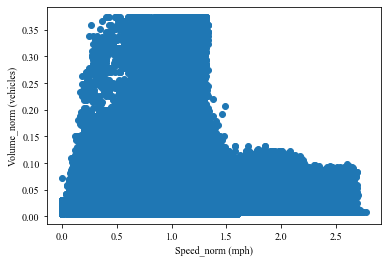

In [16]:
### scatter plots of speed_norm vs volume_norm
fig = plt.figure()
ax = fig.add_subplot(111) # projection='3d'

miami_traffic_zone_plot = miami_traffic_zone.loc[miami_traffic_zone['speed'] >= 0].loc[miami_traffic_zone['volume'] >= 0]

# Plot the contour surface
ax.scatter(miami_traffic_zone_plot['speed_norm'].to_numpy(), miami_traffic_zone_plot['volume_norm'].to_numpy())

# Add labels and title
ax.set_xlabel('Speed_norm (mph)')
ax.set_ylabel('Volume_norm (vehicles)')
plt.show()

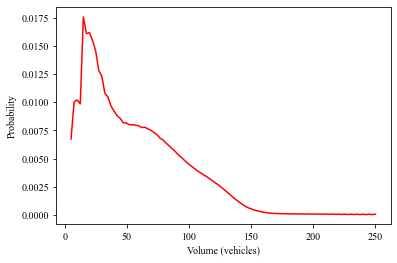

In [17]:
### hist of volume
fig = plt.figure()
ax = fig.add_subplot(111)

from scipy.stats import gaussian_kde

kde = gaussian_kde(miami_traffic_zone_plot['volume'].to_numpy())
x_vals = np.linspace(miami_traffic_zone_plot['volume'].to_numpy().min(), miami_traffic_zone_plot['volume'].to_numpy().max(), 100)
x_prob = kde(x_vals)
ax.plot(x_vals, x_prob, color='red', label='X Distribution')

# Add labels and title
ax.set_xlabel('Volume (vehicles)')
ax.set_ylabel('Probability')

# Display the plot
plt.show()

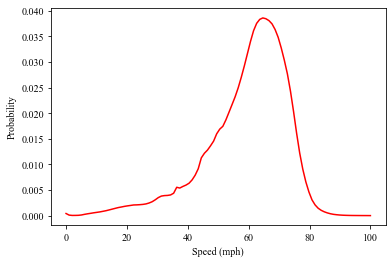

In [18]:
### hist of speed
fig = plt.figure()
ax = fig.add_subplot(111)

from scipy.stats import gaussian_kde

kde = gaussian_kde(miami_traffic_zone_plot['speed'].to_numpy())
x_vals = np.linspace(miami_traffic_zone_plot['speed'].to_numpy().min(), miami_traffic_zone_plot['speed'].to_numpy().max(), 100)
x_prob = kde(x_vals)
ax.plot(x_vals, x_prob, color='red', label='X Distribution')

# Add labels and title
ax.set_xlabel('Speed (mph)')
ax.set_ylabel('Probability')

# Display the plot
plt.show()

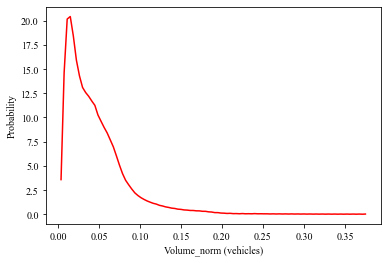

In [19]:
### hist of volume_norm
fig = plt.figure()
ax = fig.add_subplot(111)

from scipy.stats import gaussian_kde

kde = gaussian_kde(miami_traffic_zone_plot['volume_norm'].to_numpy())
x_vals = np.linspace(miami_traffic_zone_plot['volume_norm'].to_numpy().min(), miami_traffic_zone_plot['volume_norm'].to_numpy().max(), 100)
x_prob = kde(x_vals)
ax.plot(x_vals, x_prob, color='red', label='X Distribution')

# Add labels and title
ax.set_xlabel('Volume_norm (vehicles)')
ax.set_ylabel('Probability')

# Display the plot
plt.show()

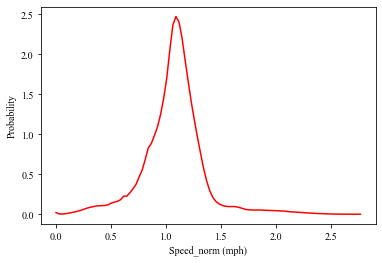

In [20]:
### hist of speed_norm
fig = plt.figure()
ax = fig.add_subplot(111)

from scipy.stats import gaussian_kde

kde = gaussian_kde(miami_traffic_zone_plot['speed_norm'].to_numpy())
x_vals = np.linspace(miami_traffic_zone_plot['speed_norm'].to_numpy().min(), miami_traffic_zone_plot['speed_norm'].to_numpy().max(), 100)
x_prob = kde(x_vals)
ax.plot(x_vals, x_prob, color='red', label='X Distribution')

# Add labels and title
ax.set_xlabel('Speed_norm (mph)')
ax.set_ylabel('Probability')

# Display the plot
plt.show()

##### Calculate

In [21]:
## 7 = 0
def day_to_day_of_week(aaa):
    return aaa - int(aaa/7) * 7

# to handle missing data for each day
zone_id_list = list(miami_traffic_zone['zone_id'].unique()) # only keep zone id with traffic data
print(len(zone_id_list))
miami_traffic_zone_id_volume_mean = [] #np.zeros((len(zone_id_list), 288)) ## 12*24
miami_traffic_zone_id_speed_mean = []
zone_id_list_sel = []
for zone_id in zone_id_list:
    miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id]
    miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)
    t00 = pd.Timestamp('2019-08-30 00:00:00', tz='UTC')
    t11 = pd.Timestamp('2019-09-06 00:00:00', tz='UTC')
    miami_traffic_zone_id_pre = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] <= t00]
    miami_traffic_zone_id_post = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t11]
    miami_traffic_zone_id = pd.concat([miami_traffic_zone_id_pre, miami_traffic_zone_id_post], axis = 0).reset_index(drop=True)
    miami_traffic_zone_id['Day'] = (miami_traffic_zone_id['Time'] - miami_traffic_zone_id['Time'].iloc[0]).dt.days + 5
    miami_traffic_zone_id['Day'] = miami_traffic_zone_id['Day'].apply(day_to_day_of_week)
    miami_traffic_zone_id['Hour'] = miami_traffic_zone_id['Time'].dt.hour
    miami_traffic_zone_id['Minute'] = miami_traffic_zone_id['Time'].dt.minute
    volume_mean_array = miami_traffic_zone_id.groupby(['Day', 'Hour', 'Minute'], dropna=True)['volume_norm'].mean().values
    speed_mean_array = miami_traffic_zone_id.groupby(['Day', 'Hour', 'Minute'], dropna=True)['speed_norm'].mean().values
    if len(volume_mean_array) == 2016:
        miami_traffic_zone_id_volume_mean.append(volume_mean_array)
        miami_traffic_zone_id_speed_mean.append(speed_mean_array)
        zone_id_list_sel.append(zone_id)
    else:
        print(zone_id)
print(len(zone_id_list_sel))

702
10277.0
10335.0
2834.0
3677.0
5114.0
5115.0
696


In [22]:
# define time order of one day to guarantee 288 data samples for each day
zone_id = zone_id_list_sel[0]
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)
t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
miami_daily_order_o = miami_traffic_zone_id_daily[['Time', 'zone_id']] # the first day
len(miami_daily_order_o)

288

##### address missing data for all time periods

In [23]:
## start: Friday, end: Friday: 7/5-10/4: Hurricane Dorian: 8/30-9/5
speed_resilience = []
volume_resilience = []
speed_performance = [[], []]
volume_performance = [[], []]

disrupt_index_list = list(np.arange(56, 63))
norm_index_list = list(np.arange(56)) + list(np.arange(63, 91))

# define time order of one day
zone_id = zone_id_list_sel[0]
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)
t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
miami_daily_order_o = miami_traffic_zone_id_daily[['Time', 'zone_id']] # the first day

for kkk in range(len(zone_id_list_sel)):
    zone_id = zone_id_list_sel[kkk]
    miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id]
    miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)
    daily_mean_volume_norm = []
    daily_med_speed_norm = []
    t1 = start_datetime
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order = miami_daily_order_o.copy()
    for i in range (91):
        miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
        miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
        miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'volume_norm', 'speed_norm']], how = 'left', on = 'Time')
        t1 = t2
        t2 = t1 + pd.DateOffset(days=1)
        miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
        # Fill the NaN values in column 'A' with corresponding values from the other array
        day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6
        nan_locs = miami_daily_order['volume_norm'].isna()
        miami_daily_order.loc[nan_locs, 'volume_norm'] = miami_traffic_zone_id_volume_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
        nan_locs = miami_daily_order['speed_norm'].isna()
        miami_daily_order.loc[nan_locs, 'speed_norm'] = miami_traffic_zone_id_speed_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
        
        if len(miami_daily_order) - np.sum(np.isnan(miami_daily_order['volume_norm'])) == 288:
            daily_mean_volume_norm.append(np.nanmean(miami_daily_order['volume_norm']))
        else:
            daily_mean_volume_norm.append(np.nan)
        if len(miami_daily_order) - np.sum(np.isnan(miami_daily_order['speed_norm'])) == 288:
            daily_med_speed_norm.append(np.nanmedian(miami_daily_order['speed_norm']))
        else:
            daily_med_speed_norm.append(np.nan)
            
    daily_mean_volume_norm = np.array(daily_mean_volume_norm)
    daily_med_speed_norm = np.array(daily_med_speed_norm)
    disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
    disrupt_speed_norm = np.nanmean(daily_med_speed_norm[disrupt_index_list])
    norm_volume_norm = np.nanmean(daily_mean_volume_norm[norm_index_list])
    norm_speed_norm = np.nanmean(daily_med_speed_norm[norm_index_list])
    speed_resilience.append(disrupt_speed_norm - norm_speed_norm)
    volume_resilience.append(disrupt_volume_norm - norm_volume_norm)
    speed_performance[0].append(disrupt_speed_norm)
    speed_performance[1].append(norm_speed_norm)
    volume_performance[0].append(disrupt_volume_norm)
    volume_performance[1].append(norm_volume_norm)

resilience_zone_id_df = pd.DataFrame({'zone_id': zone_id_list_sel,
                                      'volume_resilience': volume_resilience,
                                      'speed_resilience': speed_resilience})

print('count:', len(resilience_zone_id_df))
resilience_zone_id_df.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:54: RuntimeWarning: Mean of empty slice
  disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:55: RuntimeWarning: Mean of empty slice
  disrupt_speed_norm = np.nanmean(daily_med_speed_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:56: RuntimeWarning: Mean of empty slice
  norm_volume_norm = np.nanmean(daily_mean_volume_norm[norm_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:57: RuntimeWarning: Mean of empty slice
  norm_speed_norm = np.nanmean(daily_med_speed_norm[norm_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:54: RuntimeWarning: Mean of empty slice
  disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:55: RuntimeWarning: M

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:54: RuntimeWarning: Mean of empty slice
  disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:55: RuntimeWarning: Mean of empty slice
  disrupt_speed_norm = np.nanmean(daily_med_speed_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:56: RuntimeWarning: Mean of empty slice
  norm_volume_norm = np.nanmean(daily_mean_volume_norm[norm_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:57: RuntimeWarning: Mean of empty slice
  norm_speed_norm = np.nanmean(daily_med_speed_norm[norm_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:54: RuntimeWarning: Mean of empty slice
  disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:55: RuntimeWarning: M

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:54: RuntimeWarning: Mean of empty slice
  disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:55: RuntimeWarning: Mean of empty slice
  disrupt_speed_norm = np.nanmean(daily_med_speed_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:56: RuntimeWarning: Mean of empty slice
  norm_volume_norm = np.nanmean(daily_mean_volume_norm[norm_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:57: RuntimeWarning: Mean of empty slice
  norm_speed_norm = np.nanmean(daily_med_speed_norm[norm_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:54: RuntimeWarning: Mean of empty slice
  disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\2465623972.py:55: RuntimeWarning: M

count: 696


,zone_id,volume_resilience,speed_resilience
0,10188.0,-0.008148,0.003341
1,10189.0,-0.007176,0.001154
2,10192.0,-0.007835,-0.001371
3,10193.0,-0.008330,0.010788
4,10194.0,-0.006080,-0.000885


In [24]:
resilience_zone_id_df_nonnan = resilience_zone_id_df.dropna() # drop 56 rows: from 696 to 667
print('count:', len(resilience_zone_id_df))
print('count:', len(resilience_zone_id_df_nonnan))
resilience_zone_id_df.head()

count: 696
count: 667


,zone_id,volume_resilience,speed_resilience
0,10188.0,-0.008148,0.003341
1,10189.0,-0.007176,0.001154
2,10192.0,-0.007835,-0.001371
3,10193.0,-0.008330,0.010788
4,10194.0,-0.006080,-0.000885


In [25]:
resilience_zone_id_df[['volume_resilience', 'speed_resilience']].describe()

,volume_resilience,speed_resilience
count,667.000000,667.000000
mean,-0.008201,0.021778
std,0.005608,0.037140
min,-0.042099,-0.239007
25%,-0.010309,0.002236
50%,-0.007319,0.015118
75%,-0.004819,0.036380
max,0.000102,0.257555


### From Friday to Friday: 7/5-10/4 for the first zone id

In [26]:
## start: Friday, end: Friday
speed_resilience = []
volume_resilience = []
kkk = 0
start_datetime = pd.Timestamp('2019-07-05 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 7, 1, 0, 0))
end_datetime = pd.Timestamp('2019-10-04 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 10, 1, 0, 0))
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id_list_sel[kkk]]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] >= start_datetime]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] <= end_datetime]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)
miami_traffic_zone_id.head()

,Time,zone_id,speed,volume,speed_norm,volume_norm
0,2019-07-05 00:00:00+00:00,10188.0,66.233193,11.75,1.103887,0.017625
1,2019-07-05 00:05:00+00:00,10188.0,72.226496,14.75,1.203775,0.022125
2,2019-07-05 00:10:00+00:00,10188.0,72.432353,14.75,1.207206,0.022125
3,2019-07-05 00:15:00+00:00,10188.0,72.536765,14.25,1.208946,0.021375
4,2019-07-05 00:20:00+00:00,10188.0,71.445833,14.50,1.190764,0.021750


In [27]:
len(miami_traffic_zone_id)

26178

#### volume norm

volume resilience: -0.008148086144179896


Text(0, 0.5, 'Daily average normalized volume')

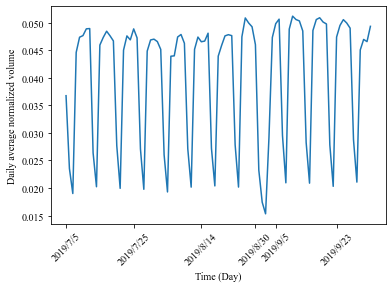

In [28]:
t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
daily_mean_volume_norm = []
miami_daily_order = miami_daily_order_o.copy()
kkk = 0

for i in range (91): 
    miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
    miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
    miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'volume_norm']], how = 'left', on = 'Time')
    t1 = t2
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
    # Fill the NaN values in column 'A' with corresponding values from the other array
    day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6    
    nan_locs = miami_daily_order['volume_norm'].isna()
    miami_daily_order.loc[nan_locs, 'volume_norm'] = miami_traffic_zone_id_volume_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
    daily_mean_volume_norm.append(np.nanmean(miami_daily_order['volume_norm']))

print('volume resilience:', resilience_zone_id_df['volume_resilience'].iloc[kkk])
plt.plot(daily_mean_volume_norm)
plt.xlabel('Time (Day)')
plt.xticks(ticks = [0, 20, 40, 56, 62, 80], labels=['2019/7/5', '2019/7/25', '2019/8/14', '2019/8/30', '2019/9/5', '2019/9/23'])
plt.xticks(rotation = 45)
plt.ylabel('Daily average normalized volume')

In [29]:
daily_mean_volume_norm = np.array(daily_mean_volume_norm)
disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
norm_volume_norm = np.nanmean(daily_mean_volume_norm[norm_index_list])
disrupt_volume_norm - norm_volume_norm

-0.008148086144179896

#### speed norm

speed resilience: 0.003340885591295306


Text(0, 0.5, 'Daily median normalized speed')

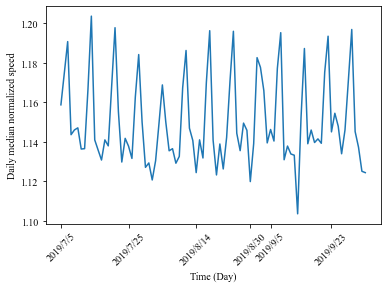

In [30]:
t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
daily_med_speed_norm = []
miami_daily_order = miami_daily_order_o.copy()
kkk = 0

for i in range (91): 
    miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
    miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
    miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'speed_norm']], how = 'left', on = 'Time')
    t1 = t2
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
    # Fill the NaN values in column 'A' with corresponding values from the other array
    day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6    
    nan_locs = miami_daily_order['speed_norm'].isna()
    miami_daily_order.loc[nan_locs, 'speed_norm'] = miami_traffic_zone_id_speed_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
    daily_med_speed_norm.append(np.nanmedian(miami_daily_order['speed_norm']))

print('speed resilience:', resilience_zone_id_df['speed_resilience'].iloc[kkk])
plt.plot(daily_med_speed_norm)
plt.xlabel('Time (Day)')
plt.xticks(ticks = [0, 20, 40, 56, 62, 80], labels=['2019/7/5', '2019/7/25', '2019/8/14', '2019/8/30', '2019/9/5', '2019/9/23'])
plt.xticks(rotation = 45)
plt.ylabel('Daily median normalized speed')

In [31]:
daily_med_speed_norm = np.array(daily_med_speed_norm)
disrupt_speed_norm = np.nanmean(daily_med_speed_norm[disrupt_index_list])
norm_speed_norm = np.nanmean(daily_med_speed_norm[norm_index_list])
disrupt_speed_norm - norm_speed_norm

0.003340885591295306

### Integrate Influencing Factors With Resilience Index

In [32]:
resilience_zone_id_attr = resilience_zone_id_df.merge(influencing_factor_attribute, how='left', on='zone_id')
# resilience_influencing_factor_attribute = resilience_influencing_factor_attribute.loc[~resilience_influencing_factor_attribute['resilience'].isnull()]
resilience_zone_id_attr.head()

,zone_id,volume_resilience,speed_resilience,state,road,direction,lane_type,length,LND,latitude,...,gw_lu_diversity,gw_highway_density,gw_major_road_density,clustering_coefficient,degree_centrality,closeness_centrality,Evac_Route_Index,geometry,default_speed,Capacity (v/5min)
0,10188.0,-0.008148,0.003341,MDX,SR-924,East,Unknown,0.33,1.890754,25.892686,...,1.667085,0.002632,0.011679,0.166667,0.004071,0.004071,1.0,POINT (-80.27885 25.89269),60.0,666.666667
1,10189.0,-0.007176,0.001154,MDX,SR-924,West,Unknown,0.33,1.890754,25.892686,...,1.667085,0.002632,0.011679,0.166667,0.004071,0.004071,1.0,POINT (-80.27885 25.89269),60.0,666.666667
2,10192.0,-0.007835,-0.001371,MDX,SR-924,West,Unknown,0.33,2.233880,25.895786,...,1.652271,0.002596,0.011718,0.166667,0.004071,0.004846,1.0,POINT (-80.28299 25.89579),60.0,666.666667
3,10193.0,-0.008330,0.010788,MDX,SR-924,East,Unknown,0.33,2.233880,25.895786,...,1.652271,0.002596,0.011718,0.166667,0.004071,0.004846,1.0,POINT (-80.28299 25.89579),60.0,666.666667
4,10194.0,-0.006080,-0.000885,MDX,SR-924,West,Unknown,0.33,2.978398,25.885639,...,1.651300,0.002506,0.011810,0.000000,0.002714,0.003053,1.0,POINT (-80.26826 25.88564),60.0,666.666667


In [33]:
np.sum(resilience_zone_id_attr.isnull())

zone_id                    0
volume_resilience         29
speed_resilience          29
state                      0
road                       0
direction                  0
lane_type                  0
length                    85
LND                        0
latitude                   0
longitude                  0
gw_population_density      0
gw_male_ratio              0
gw_white_ratio             0
gw_median_age              0
gw_education               0
gw_commute_by_car          0
gw_household_income        0
gw_car_ownership           0
gw_employment_density      0
gw_lu_diversity            0
gw_highway_density         0
gw_major_road_density      0
clustering_coefficient     0
degree_centrality          0
closeness_centrality       0
Evac_Route_Index           0
geometry                   0
default_speed              0
Capacity (v/5min)          0
dtype: int64

In [34]:
# data processing
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
imputer = imputer.fit(resilience_zone_id_attr[['length']])
resilience_zone_id_attr[['length']] = imputer.transform(resilience_zone_id_attr[['length']])

np.sum(resilience_zone_id_attr.isnull())

zone_id                    0
volume_resilience         29
speed_resilience          29
state                      0
road                       0
direction                  0
lane_type                  0
length                     0
LND                        0
latitude                   0
longitude                  0
gw_population_density      0
gw_male_ratio              0
gw_white_ratio             0
gw_median_age              0
gw_education               0
gw_commute_by_car          0
gw_household_income        0
gw_car_ownership           0
gw_employment_density      0
gw_lu_diversity            0
gw_highway_density         0
gw_major_road_density      0
clustering_coefficient     0
degree_centrality          0
closeness_centrality       0
Evac_Route_Index           0
geometry                   0
default_speed              0
Capacity (v/5min)          0
dtype: int64

In [35]:
# store data
# resilience_zone_id_attr.to_csv('Excel/resilience_zone_id_attr_BART_final_sel_week_all.csv', index = False)
# resilience_zone_id_attr.head()
print(np.sum(resilience_zone_id_attr['Evac_Route_Index']))
resilience_zone_id_attr.describe()

563.0


,zone_id,volume_resilience,speed_resilience,length,LND,latitude,longitude,gw_population_density,gw_male_ratio,gw_white_ratio,...,gw_employment_density,gw_lu_diversity,gw_highway_density,gw_major_road_density,clustering_coefficient,degree_centrality,closeness_centrality,Evac_Route_Index,default_speed,Capacity (v/5min)
count,696.000000,667.000000,667.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,...,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,7783.135057,-0.008201,0.021778,0.337872,3.585041,25.821214,-80.274214,17.871091,0.483833,0.611260,...,9.200667,1.758734,0.003322,0.012101,0.162495,0.003609,0.004381,0.808908,56.329023,1326.867816
std,4295.524088,0.005608,0.037140,0.070823,1.111743,0.114642,0.078308,6.651186,0.012393,0.160617,...,4.313833,0.152994,0.000940,0.002181,0.105534,0.001626,0.001932,0.393444,7.965361,438.890423
min,2560.000000,-0.042099,-0.239007,0.140000,1.141347,25.439007,-80.475169,7.949113,0.456576,0.305367,...,3.191846,1.539893,0.001626,0.008272,0.000000,0.001357,0.001357,0.000000,35.000000,666.666667
25%,2993.250000,-0.010309,0.002236,0.330000,2.808660,25.777398,-80.349161,12.958042,0.474015,0.469162,...,6.043867,1.650404,0.002759,0.010560,0.075000,0.002714,0.003053,1.000000,55.000000,900.000000
50%,10209.500000,-0.007319,0.015118,0.340000,3.594869,25.819669,-80.250764,16.870419,0.480317,0.635658,...,8.272031,1.682252,0.003294,0.011770,0.250000,0.002714,0.004071,1.000000,55.000000,1333.333333
75%,11006.500000,-0.004819,0.036380,0.350000,4.266893,25.924780,-80.206521,20.411451,0.489639,0.749508,...,10.486912,1.907897,0.003705,0.013552,0.250000,0.004071,0.005427,1.000000,60.000000,1833.333333
max,14747.000000,0.000102,0.257555,1.200000,6.441721,25.971000,-80.141397,46.889735,0.521904,0.828762,...,28.512988,2.356870,0.006832,0.019035,0.314980,0.016282,0.016282,1.000000,70.000000,1833.333333


#### Descriptive statistics

In [36]:
resilience_zone_id_attr.columns

Index(['zone_id', 'volume_resilience', 'speed_resilience', 'state', 'road',
       'direction', 'lane_type', 'length', 'LND', 'latitude', 'longitude',
       'gw_population_density', 'gw_male_ratio', 'gw_white_ratio',
       'gw_median_age', 'gw_education', 'gw_commute_by_car',
       'gw_household_income', 'gw_car_ownership', 'gw_employment_density',
       'gw_lu_diversity', 'gw_highway_density', 'gw_major_road_density',
       'clustering_coefficient', 'degree_centrality', 'closeness_centrality',
       'Evac_Route_Index', 'geometry', 'default_speed', 'Capacity (v/5min)'],
      dtype='object')

In [37]:
resilience_zone_id_attr[['zone_id', 'volume_resilience', 'speed_resilience', 'state', 'road',
       'direction', 'lane_type', 'length', 'LND', 'latitude', 'longitude',
       'gw_population_density', 'gw_male_ratio', 'gw_white_ratio',
       'gw_median_age', 'gw_education', 'gw_commute_by_car']].describe()

,zone_id,volume_resilience,speed_resilience,length,LND,latitude,longitude,gw_population_density,gw_male_ratio,gw_white_ratio,gw_median_age,gw_education,gw_commute_by_car
count,696.000000,667.000000,667.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,7783.135057,-0.008201,0.021778,0.337872,3.585041,25.821214,-80.274214,17.871091,0.483833,0.611260,40.205342,2.725004,0.835029
std,4295.524088,0.005608,0.037140,0.070823,1.111743,0.114642,0.078308,6.651186,0.012393,0.160617,2.490506,0.217131,0.066017
min,2560.000000,-0.042099,-0.239007,0.140000,1.141347,25.439007,-80.475169,7.949113,0.456576,0.305367,30.389560,2.359625,0.645220
25%,2993.250000,-0.010309,0.002236,0.330000,2.808660,25.777398,-80.349161,12.958042,0.474015,0.469162,38.491784,2.551226,0.804955
50%,10209.500000,-0.007319,0.015118,0.340000,3.594869,25.819669,-80.250764,16.870419,0.480317,0.635658,40.420127,2.672578,0.855495
75%,11006.500000,-0.004819,0.036380,0.350000,4.266893,25.924780,-80.206521,20.411451,0.489639,0.749508,41.957232,2.832444,0.883735
max,14747.000000,0.000102,0.257555,1.200000,6.441721,25.971000,-80.141397,46.889735,0.521904,0.828762,44.512021,3.369859,0.915155


In [38]:
resilience_zone_id_attr[['gw_household_income', 'gw_car_ownership', 'gw_employment_density',
       'gw_lu_diversity', 'gw_highway_density', 'gw_major_road_density',
       'clustering_coefficient', 'degree_centrality', 'closeness_centrality',
       'Evac_Route_Index', 'geometry', 'default_speed', 'Capacity (v/5min)']].describe()

,gw_household_income,gw_car_ownership,gw_employment_density,gw_lu_diversity,gw_highway_density,gw_major_road_density,clustering_coefficient,degree_centrality,closeness_centrality,Evac_Route_Index,default_speed,Capacity (v/5min)
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,2.569377,1.629255,9.200667,1.758734,0.003322,0.012101,0.162495,0.003609,0.004381,0.808908,56.329023,1326.867816
std,0.214919,0.262670,4.313833,0.152994,0.000940,0.002181,0.105534,0.001626,0.001932,0.393444,7.965361,438.890423
min,2.272886,1.060310,3.191846,1.539893,0.001626,0.008272,0.000000,0.001357,0.001357,0.000000,35.000000,666.666667
25%,2.396659,1.418931,6.043867,1.650404,0.002759,0.010560,0.075000,0.002714,0.003053,1.000000,55.000000,900.000000
50%,2.527081,1.677049,8.272031,1.682252,0.003294,0.011770,0.250000,0.002714,0.004071,1.000000,55.000000,1333.333333
75%,2.719946,1.829768,10.486912,1.907897,0.003705,0.013552,0.250000,0.004071,0.005427,1.000000,60.000000,1833.333333
max,3.239017,1.996570,28.512988,2.356870,0.006832,0.019035,0.314980,0.016282,0.016282,1.000000,70.000000,1833.333333


### Read Resilience File and Data Pre-processing

In [39]:
resilience_zone_id_attr = pd.read_csv('Excel/resilience_zone_id_attr_BART_final_sel_week_all.csv') 
resilience_zone_id_attr['geometry'] = resilience_zone_id_attr[['longitude', 'latitude']].values.tolist()
resilience_zone_id_attr['geometry'] = resilience_zone_id_attr['geometry'].apply(Point)
resilience_zone_id_attr = gpd.GeoDataFrame(resilience_zone_id_attr)

resilience_zone_id_attr = resilience_zone_id_attr.drop(columns = ['state', 'lane_type', 'length', 'default_speed', 'Capacity (v/5min)'], axis = 1).set_index('zone_id')
# resilience_zone_id_attr = resilience_influencing_factor_attribute.iloc[:,0:-1]
resilience_zone_id_attr.head()

,volume_resilience,speed_resilience,road,direction,LND,latitude,longitude,gw_population_density,gw_male_ratio,gw_white_ratio,...,gw_car_ownership,gw_employment_density,gw_lu_diversity,gw_highway_density,gw_major_road_density,clustering_coefficient,degree_centrality,closeness_centrality,Evac_Route_Index,geometry
zone_id,,,,,,,,,,,,,,,,,,,,,
10188.0,-0.008148,0.003341,SR-924,East,1.890754,25.892686,-80.278848,15.479992,0.471857,0.588763,...,1.705898,7.345682,1.667085,0.002632,0.011679,0.166667,0.004071,0.004071,1.0,POINT (-80.27885 25.89269)
10189.0,-0.007176,0.001154,SR-924,West,1.890754,25.892686,-80.278848,15.479992,0.471857,0.588763,...,1.705898,7.345682,1.667085,0.002632,0.011679,0.166667,0.004071,0.004071,1.0,POINT (-80.27885 25.89269)
10192.0,-0.007835,-0.001371,SR-924,West,2.233880,25.895786,-80.282987,16.161763,0.468869,0.590953,...,1.719120,7.709759,1.652271,0.002596,0.011718,0.166667,0.004071,0.004846,1.0,POINT (-80.28299 25.89579)
10193.0,-0.008330,0.010788,SR-924,East,2.233880,25.895786,-80.282987,16.161763,0.468869,0.590953,...,1.719120,7.709759,1.652271,0.002596,0.011718,0.166667,0.004071,0.004846,1.0,POINT (-80.28299 25.89579)
10194.0,-0.006080,-0.000885,SR-924,West,2.978398,25.885639,-80.268260,15.341590,0.474062,0.553421,...,1.688978,7.182977,1.651300,0.002506,0.011810,0.000000,0.002714,0.003053,1.0,POINT (-80.26826 25.88564)


#### desrciptive statistics

In [40]:
print(resilience_zone_id_attr.info())
print(resilience_zone_id_attr.isnull().sum())

<class 'geopandas.geodataframe.GeoDataFrame'>
Float64Index: 696 entries, 10188.0 to 9766.0
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   volume_resilience       667 non-null    float64 
 1   speed_resilience        667 non-null    float64 
 2   road                    696 non-null    object  
 3   direction               696 non-null    object  
 4   LND                     696 non-null    float64 
 5   latitude                696 non-null    float64 
 6   longitude               696 non-null    float64 
 7   gw_population_density   696 non-null    float64 
 8   gw_male_ratio           696 non-null    float64 
 9   gw_white_ratio          696 non-null    float64 
 10  gw_median_age           696 non-null    float64 
 11  gw_education            696 non-null    float64 
 12  gw_commute_by_car       696 non-null    float64 
 13  gw_household_income     696 non-null    float64 
 14  gw_car_

In [41]:
resilience_zone_id_attr.describe()

,volume_resilience,speed_resilience,LND,latitude,longitude,gw_population_density,gw_male_ratio,gw_white_ratio,gw_median_age,gw_education,...,gw_household_income,gw_car_ownership,gw_employment_density,gw_lu_diversity,gw_highway_density,gw_major_road_density,clustering_coefficient,degree_centrality,closeness_centrality,Evac_Route_Index
count,667.000000,667.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,...,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,-0.008201,0.021778,3.585041,25.821214,-80.274214,17.871091,0.483833,0.611260,40.205342,2.725004,...,2.569377,1.629255,9.200667,1.758734,0.003322,0.012101,0.162495,0.003609,0.004381,0.808908
std,0.005608,0.037140,1.111743,0.114642,0.078308,6.651186,0.012393,0.160617,2.490506,0.217131,...,0.214919,0.262670,4.313833,0.152994,0.000940,0.002181,0.105534,0.001626,0.001932,0.393444
min,-0.042099,-0.239007,1.141347,25.439007,-80.475169,7.949113,0.456576,0.305367,30.389560,2.359625,...,2.272886,1.060310,3.191846,1.539893,0.001626,0.008272,0.000000,0.001357,0.001357,0.000000
25%,-0.010309,0.002236,2.808660,25.777398,-80.349161,12.958042,0.474015,0.469162,38.491784,2.551226,...,2.396659,1.418931,6.043867,1.650404,0.002759,0.010560,0.075000,0.002714,0.003053,1.000000
50%,-0.007319,0.015118,3.594869,25.819669,-80.250764,16.870419,0.480317,0.635658,40.420127,2.672578,...,2.527081,1.677049,8.272031,1.682252,0.003294,0.011770,0.250000,0.002714,0.004071,1.000000
75%,-0.004819,0.036380,4.266893,25.924780,-80.206521,20.411451,0.489639,0.749508,41.957232,2.832444,...,2.719946,1.829768,10.486912,1.907897,0.003705,0.013552,0.250000,0.004071,0.005427,1.000000
max,0.000102,0.257555,6.441721,25.971000,-80.141397,46.889735,0.521904,0.828762,44.512021,3.369859,...,3.239017,1.996570,28.512988,2.356870,0.006832,0.019035,0.314980,0.016282,0.016282,1.000000


##### Spatial distribution

In [65]:
from scipy.spatial.distance import cdist

def moran_volume_resilience(gdf):
        
    # --- Extract geometry and attribute values ---
    gdf.geometry = gdf.geometry.to_crs(epsg=26917) # set_crs(epsg=4326).
    coords = np.array([(geom.x, geom.y) for geom in gdf.geometry])
    x = gdf['volume_resilience'].values

    # --- Build inverse distance weight matrix ---
    dist_matrix = cdist(coords, coords) / 1000
    np.fill_diagonal(dist_matrix, np.nan)  # avoid divide-by-zero
    W = 1 / (dist_matrix + 1e-6)
    W = np.nan_to_num(W, nan=0.0)

    # --- Row-standardize weight matrix (optional but common) ---
    W = W / W.sum(axis=1, keepdims=True)

    # --- Calculate Moran’s I manually ---
    x_bar = np.mean(x)
    z = x - x_bar
    n = len(x)

    num = np.sum(W * np.outer(z, z))
    den = np.sum(z**2)
    moran_I = (n / np.sum(W)) * (num / den)

    return moran_I

def moran_speed_resilience(gdf):
        
    # --- Extract geometry and attribute values ---
    gdf.geometry = gdf.geometry.to_crs(epsg=26917) # set_crs(epsg=4326).
    coords = np.array([(geom.x, geom.y) for geom in gdf.geometry])
    x = gdf['speed_resilience'].values

    # --- Build inverse distance weight matrix ---
    dist_matrix = cdist(coords, coords) / 1000
    np.fill_diagonal(dist_matrix, np.nan)  # avoid divide-by-zero
    W = 1 / (dist_matrix + 1e-6)
    W = np.nan_to_num(W, nan=0.0)

    # --- Row-standardize weight matrix (optional but common) ---
    W = W / W.sum(axis=1, keepdims=True)

    # --- Calculate Moran’s I manually ---
    x_bar = np.mean(x)
    z = x - x_bar
    n = len(x)

    num = np.sum(W * np.outer(z, z))
    den = np.sum(z**2)
    moran_I = (n / np.sum(W)) * (num / den)

    return moran_I

In [72]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import norm

def moran_volume_resilience(gdf):
    # --- Extract geometry and attribute values ---
    gdf = gdf.to_crs(epsg=26917)
    coords = np.array([(geom.x, geom.y) for geom in gdf.geometry])
    x = gdf['volume_resilience'].values
    n = len(x)

    # --- Build inverse distance weight matrix ---
    dist_matrix = cdist(coords, coords) / 1000
    np.fill_diagonal(dist_matrix, np.nan)
    W = 1 / (dist_matrix + 1e-6)
    W = np.nan_to_num(W, nan=0.0)

    # --- Row-standardize ---
    W = W / W.sum(axis=1, keepdims=True)

    # --- Moran’s I ---
    x_bar = np.mean(x)
    z = x - x_bar
    num = np.sum(W * np.outer(z, z))
    den = np.sum(z**2)
    moran_I = (n / np.sum(W)) * (num / den)

    # --- Expected Moran’s I ---
    EI = -1 / (n - 1)

    # --- Compute S0, S1, S2 for variance ---
    S0 = np.sum(W)
    W_sym = (W + W.T) / 2
    S1 = 0.5 * np.sum((W + W.T)**2)
    row_sums = np.sum(W + W.T, axis=1)
    S2 = np.sum(row_sums**2)

    varI = (n*((n**2 - 3*n + 3)*S1 - n*S2 + 3*S0**2) -
            (EI**2)*(n**2 - 1)*S0**2) / ((n-1)*(n-2)*(n-3)*S0**2) - EI**2

    # --- Z-score and p-value ---
    z_score = (moran_I - EI) / np.sqrt(varI)
    p_value = 2 * (1 - norm.cdf(abs(z_score)))

    return moran_I, z_score, p_value

def moran_speed_resilience(gdf):
    # --- Extract geometry and attribute values ---
    gdf = gdf.to_crs(epsg=26917)
    coords = np.array([(geom.x, geom.y) for geom in gdf.geometry])
    x = gdf['speed_resilience'].values
    n = len(x)

    # --- Build inverse distance weight matrix ---
    dist_matrix = cdist(coords, coords) / 1000
    np.fill_diagonal(dist_matrix, np.nan)
    W = 1 / (dist_matrix + 1e-6)
    W = np.nan_to_num(W, nan=0.0)

    # --- Row-standardize ---
    W = W / W.sum(axis=1, keepdims=True)

    # --- Moran’s I ---
    x_bar = np.mean(x)
    z = x - x_bar
    num = np.sum(W * np.outer(z, z))
    den = np.sum(z**2)
    moran_I = (n / np.sum(W)) * (num / den)

    # --- Expected Moran’s I ---
    EI = -1 / (n - 1)

    # --- Compute S0, S1, S2 for variance ---
    S0 = np.sum(W)
    W_sym = (W + W.T) / 2
    S1 = 0.5 * np.sum((W + W.T)**2)
    row_sums = np.sum(W + W.T, axis=1)
    S2 = np.sum(row_sums**2)

    varI = (n*((n**2 - 3*n + 3)*S1 - n*S2 + 3*S0**2) -
            (EI**2)*(n**2 - 1)*S0**2) / ((n-1)*(n-2)*(n-3)*S0**2) - EI**2

    # --- Z-score and p-value ---
    z_score = (moran_I - EI) / np.sqrt(varI)
    p_value = 2 * (1 - norm.cdf(abs(z_score)))

    return moran_I, z_score, p_value

###### Volume Resilience

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_17036\1071429756.py:20: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  resilience_zone_id_attr_new.loc[phase_positive].plot(color='white', marker='o', linewidth = 1, markersize = resilience_zone_id_attr_new.loc[phase_positive].volume_resilience * 10000,


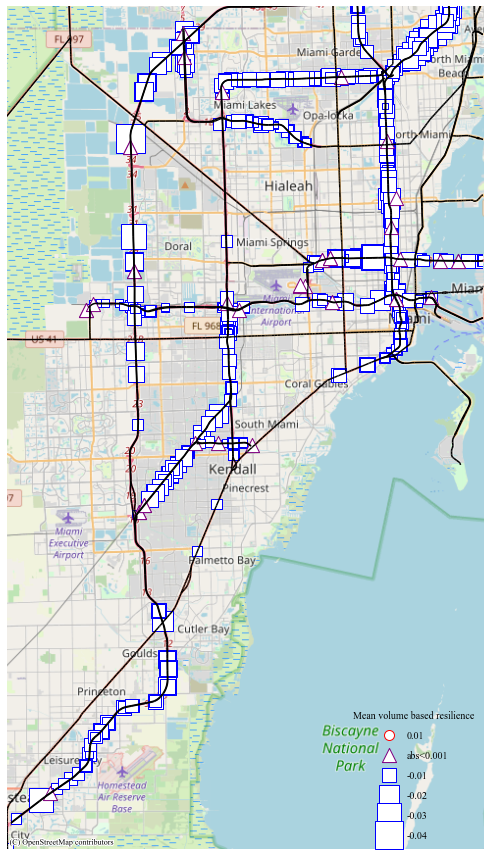

In [42]:
import contextily as ctx

miami_highway_network_new = gpd.read_file('Data/Highway.geojson').to_crs(epsg=3857)

resilience_zone_id_attr_new = gpd.GeoDataFrame(resilience_zone_id_attr)
resilience_zone_id_attr_new['geometry'] = resilience_zone_id_attr_new['geometry'].set_crs(epsg=4326).to_crs(epsg=3857) # set_crs(epsg=4326).

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
divider = make_axes_locatable(ax)

base1 = miami_highway_network_new.plot(ax=ax, edgecolor='black', facecolor='none')

phase_positive = resilience_zone_id_attr_new['volume_resilience'].values >= 0.001
phase_negative = resilience_zone_id_attr_new['volume_resilience'].values <= -0.001
phase_neutral = np.abs(resilience_zone_id_attr_new['volume_resilience'].values) < 0.001

resilience_zone_id_attr_new.loc[phase_negative].plot(color='white', marker='s', linewidth = 1, markersize = - resilience_zone_id_attr_new.loc[phase_negative].volume_resilience * 20000, 
                                                     edgecolor = 'blue', legend=True, alpha = 1, ax = base1)
resilience_zone_id_attr_new.loc[phase_positive].plot(color='white', marker='o', linewidth = 1, markersize = resilience_zone_id_attr_new.loc[phase_positive].volume_resilience * 10000, 
                                                     edgecolor = 'red', legend=True, alpha = 1, ax = base1)

resilience_zone_id_attr_new.loc[phase_neutral].plot(color='white', marker='^', linewidth = 1, markersize = 200, 
                                                    edgecolor = 'purple', legend=True, alpha = 1, ax = base1)
 
### Positive
# Customizing the legend for marker sizes
sizes = [0.01]  # Example sizes you have used in your plot
labels = [f'{size}' for size in sizes]

# Plotting dummy points to show legend with desired sizes
for size, label in zip(sizes, labels):
    ax.scatter([], [], color='white', marker='o', edgecolor = 'red', s = size * 10000, label=label)

### Neutral
# Customizing the legend for marker sizes
sizes = [0.001]  # Example sizes you have used in your plot
labels = ['abs<0.001']

# Plotting dummy points to show legend with desired sizes
for size, label in zip(sizes, labels):
    ax.scatter([], [], color='white', marker='^', edgecolor = 'purple', s=200, label=label)  

### Negative
# Customizing the legend for marker sizes
sizes = [-0.01, -0.02, -0.03, -0.04]  # Example sizes you have used in your plot
labels = [f'{size}' for size in sizes]

# Plotting dummy points to show legend with desired sizes
for size, label in zip(sizes, labels):
    ax.scatter([], [], color='white', marker='s', edgecolor = 'blue', s = - size * 20000, label=label)
    

# Adjusting legend parameters
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Mean volume based resilience', loc='lower right')

multi_line = resilience_zone_id_attr_new.geometry.unary_union

# Calculate combined bounding box
xmin, ymin, xmax, ymax = multi_line.bounds
bbox = [xmin, ymin, xmax, ymax]
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [43]:
resilience_zone_id_attr_new['volume_resilience'].describe()

count    667.000000
mean      -0.008201
std        0.005608
min       -0.042099
25%       -0.010309
50%       -0.007319
75%       -0.004819
max        0.000102
Name: volume_resilience, dtype: float64

In [44]:
print(np.sum(phase_positive), np.sum(phase_neutral), np.sum(phase_negative))

0 39 628


In [68]:
moran_volume_resilience(resilience_zone_id_attr_new[resilience_zone_id_attr_new['volume_resilience'].notna()])

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0.5544808089076657

In [73]:
moran_volume_resilience(resilience_zone_id_attr_new[resilience_zone_id_attr_new['volume_resilience'].notna()])

(0.5544808089076657, 12.994846281591068, 0.0)

In [45]:
'''
#### Positive resilience

start_datetime = pd.Timestamp('2019-07-05 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 7, 1, 0, 0))
end_datetime = pd.Timestamp('2019-10-04 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 10, 1, 0, 0))
kkk = np.where(phase_positive == True)[0][0]
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id_list_sel[kkk]]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] >= start_datetime]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] <= end_datetime]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)

t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
daily_mean_volume_norm = []
miami_daily_order = miami_daily_order_o.copy()

for i in range (91): 
    miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
    miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
    miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'volume_norm']], how = 'left', on = 'Time')
    t1 = t2
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
    # Fill the NaN values in column 'A' with corresponding values from the other array
    day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6    
    nan_locs = miami_daily_order['volume_norm'].isna()
    miami_daily_order.loc[nan_locs, 'volume_norm'] = miami_traffic_zone_id_volume_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
    daily_mean_volume_norm.append(np.nanmean(miami_daily_order['volume_norm']))

print(resilience_zone_id_attr_new['volume_resilience'].iloc[kkk])
plt.plot(daily_mean_volume_norm)
plt.xlabel('Time (Day)')
plt.xticks(ticks = [0, 20, 40, 56, 62, 80], labels=['2019/7/5', '2019/7/25', '2019/8/14', '2019/8/30', '2019/9/5', '2019/9/23'])
plt.xticks(rotation = 45)
plt.ylabel('Daily average normalized volume')
'''
print('No positive resilience')

No positive resilience


-0.0004166841953137


Text(0, 0.5, 'Daily average normalized volume')

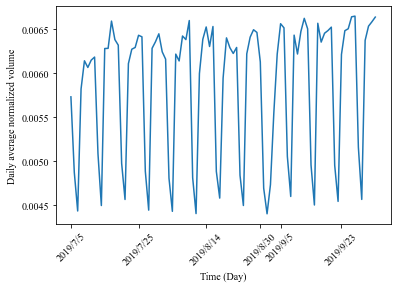

In [46]:
#### Neutral resilience

start_datetime = pd.Timestamp('2019-07-05 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 7, 1, 0, 0))
end_datetime = pd.Timestamp('2019-10-04 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 10, 1, 0, 0))
kkk = np.where(phase_neutral == True)[0][0]
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id_list_sel[kkk]]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] >= start_datetime]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] <= end_datetime]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)

t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
daily_mean_volume_norm = []
miami_daily_order = miami_daily_order_o.copy()

for i in range (91): 
    miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
    miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
    miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'volume_norm']], how = 'left', on = 'Time')
    t1 = t2
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
    # Fill the NaN values in column 'A' with corresponding values from the other array
    day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6    
    nan_locs = miami_daily_order['volume_norm'].isna()
    miami_daily_order.loc[nan_locs, 'volume_norm'] = miami_traffic_zone_id_volume_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
    daily_mean_volume_norm.append(np.nanmean(miami_daily_order['volume_norm']))
    
print(resilience_zone_id_attr_new['volume_resilience'].iloc[kkk])
plt.plot(daily_mean_volume_norm)
plt.xlabel('Time (Day)')
plt.xticks(ticks = [0, 20, 40, 56, 62, 80], labels=['2019/7/5', '2019/7/25', '2019/8/14', '2019/8/30', '2019/9/5', '2019/9/23'])
plt.xticks(rotation = 45)
plt.ylabel('Daily average normalized volume')

In [47]:
daily_mean_volume_norm = np.array(daily_mean_volume_norm)
disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
norm_volume_norm = np.nanmean(daily_mean_volume_norm[norm_index_list])
disrupt_volume_norm - norm_volume_norm

-0.0004166841953137535

-0.0068366636912814


Text(0, 0.5, 'Daily average normalized volume')

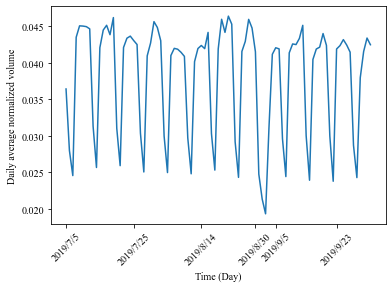

In [48]:
#### Negative resilience

start_datetime = pd.Timestamp('2019-07-05 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 7, 1, 0, 0))
end_datetime = pd.Timestamp('2019-10-04 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 10, 1, 0, 0))
kkk = np.where(phase_negative == True)[0][115]
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id_list_sel[kkk]]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] >= start_datetime]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] <= end_datetime]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)

t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
daily_mean_volume_norm = []
miami_daily_order = miami_daily_order_o.copy()

for i in range (91): 
    miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
    miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
    miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'volume_norm']], how = 'left', on = 'Time')
    t1 = t2
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
    # Fill the NaN values in column 'A' with corresponding values from the other array
    day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6    
    nan_locs = miami_daily_order['volume_norm'].isna()
    miami_daily_order.loc[nan_locs, 'volume_norm'] = miami_traffic_zone_id_volume_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
    daily_mean_volume_norm.append(np.nanmean(miami_daily_order['volume_norm']))
    
print(resilience_zone_id_attr_new['volume_resilience'].iloc[kkk])
plt.plot(daily_mean_volume_norm)
plt.xlabel('Time (Day)')
plt.xticks(ticks = [0, 20, 40, 56, 62, 80], labels=['2019/7/5', '2019/7/25', '2019/8/14', '2019/8/30', '2019/9/5', '2019/9/23'])
plt.xticks(rotation = 45)
plt.ylabel('Daily average normalized volume')

In [49]:
daily_mean_volume_norm = np.array(daily_mean_volume_norm)
disrupt_volume_norm = np.nanmean(daily_mean_volume_norm[disrupt_index_list])
norm_volume_norm = np.nanmean(daily_mean_volume_norm[norm_index_list])
disrupt_volume_norm - norm_volume_norm

-0.006836663691281435

###### Speed Resilience

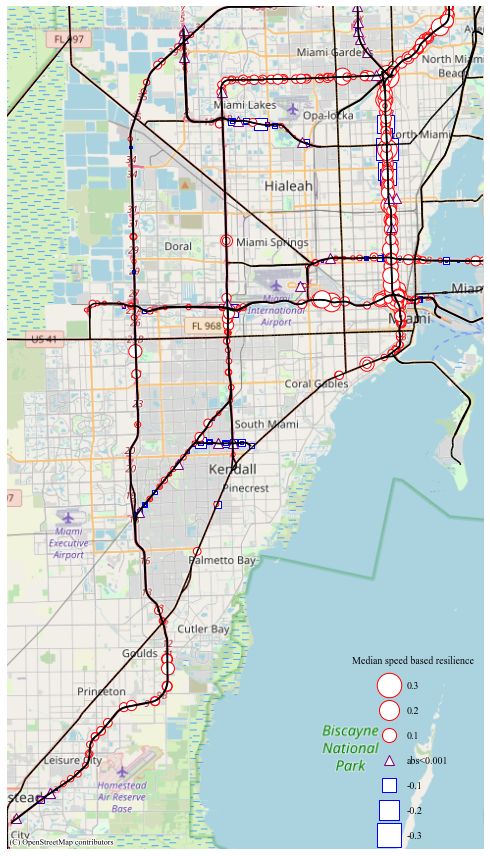

In [50]:
import contextily as ctx

miami_highway_network_new = gpd.read_file('Data/Highway.geojson').to_crs(epsg=3857)

resilience_zone_id_attr_new = gpd.GeoDataFrame(resilience_zone_id_attr)
resilience_zone_id_attr_new['geometry'] = resilience_zone_id_attr_new['geometry'].to_crs(epsg=3857) # set_crs(epsg=4326).

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
divider = make_axes_locatable(ax)

base1 = miami_highway_network_new.plot(ax=ax, edgecolor='black', facecolor='none')

phase_positive = resilience_zone_id_attr_new['speed_resilience'].values >= 0.001
phase_negative = resilience_zone_id_attr_new['speed_resilience'].values <= -0.001
phase_neutral = np.abs(resilience_zone_id_attr_new['speed_resilience'].values) < 0.001

resilience_zone_id_attr_new.loc[phase_negative].plot(color='white', marker='s', linewidth = 1, markersize = - resilience_zone_id_attr_new.loc[phase_negative].speed_resilience * 2000, 
                                                     edgecolor = 'blue', legend=True, alpha = 1, ax = base1)
resilience_zone_id_attr_new.loc[phase_positive].plot(color='white', marker='o', linewidth = 1, markersize = resilience_zone_id_attr_new.loc[phase_positive].speed_resilience * 2000, 
                                                     edgecolor = 'red', legend=True, alpha = 1, ax = base1)

resilience_zone_id_attr_new.loc[phase_neutral].plot(color='white', marker='^', linewidth = 1, markersize = 100, 
                                                    edgecolor = 'purple', legend=True, alpha = 1, ax = base1)
 
### Positive
# Customizing the legend for marker sizes
sizes = [0.3, 0.2, 0.1]  # Example sizes you have used in your plot
labels = [f'{size}' for size in sizes]

# Plotting dummy points to show legend with desired sizes
for size, label in zip(sizes, labels):
    ax.scatter([], [], color='white', marker='o', edgecolor = 'red', s = size * 2000, label=label)

### Neutral
# Customizing the legend for marker sizes
sizes = [0.001]  # Example sizes you have used in your plot
labels = ['abs<0.001']

# Plotting dummy points to show legend with desired sizes
for size, label in zip(sizes, labels):
    ax.scatter([], [], color='white', marker='^', edgecolor = 'purple', s=100, label=label)  

### Negative
# Customizing the legend for marker sizes
sizes = [-0.1, -0.2, -0.3]  # Example sizes you have used in your plot
labels = [f'{size}' for size in sizes]


# Plotting dummy points to show legend with desired sizes
for size, label in zip(sizes, labels):
    ax.scatter([], [], color='white', marker='s', edgecolor = 'blue', s = - size * 2000, label=label)
    

# Adjusting legend parameters
ax.legend(scatterpoints=1, frameon=False, labelspacing=1.5, title='Median speed based resilience', loc='lower right')

multi_line = resilience_zone_id_attr_new.geometry.unary_union

# Calculate combined bounding box
xmin, ymin, xmax, ymax = multi_line.bounds
bbox = [xmin, ymin, xmax, ymax]
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [51]:
resilience_zone_id_attr_new['speed_resilience'].describe()

count    667.000000
mean       0.021778
std        0.037140
min       -0.239007
25%        0.002236
50%        0.015118
75%        0.036380
max        0.257555
Name: speed_resilience, dtype: float64

In [52]:
print(np.sum(phase_positive), np.sum(phase_neutral), np.sum(phase_negative))

523 26 118


In [69]:
moran_speed_resilience(resilience_zone_id_attr_new[resilience_zone_id_attr_new['speed_resilience'].notna()])

0.23439410867680158

In [74]:
moran_speed_resilience(resilience_zone_id_attr_new[resilience_zone_id_attr_new['speed_resilience'].notna()])

(0.23439410867680158, 5.513533677920832, 3.516997004737732e-08)

0.0286370757601271


Text(0, 0.5, 'Daily median normalized speed')

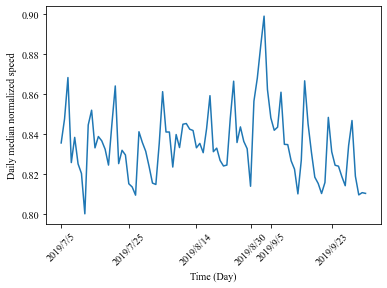

In [53]:
#### Positive resilience

start_datetime = pd.Timestamp('2019-07-05 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 7, 1, 0, 0))
end_datetime = pd.Timestamp('2019-10-04 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 10, 1, 0, 0))
kkk = np.where(phase_positive == True)[0][285]
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id_list_sel[kkk]]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] >= start_datetime]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] <= end_datetime]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)

t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
daily_med_speed_norm = []
miami_daily_order = miami_daily_order_o.copy()

for i in range (91): 
    miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
    miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
    miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'speed_norm']], how = 'left', on = 'Time')
    t1 = t2
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
    # Fill the NaN values in column 'A' with corresponding values from the other array
    day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6    
    nan_locs = miami_daily_order['speed_norm'].isna()
    miami_daily_order.loc[nan_locs, 'speed_norm'] = miami_traffic_zone_id_speed_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
    daily_med_speed_norm.append(np.nanmedian(miami_daily_order['speed_norm']))

print(resilience_zone_id_attr_new['speed_resilience'].iloc[kkk])
plt.plot(daily_med_speed_norm)
plt.xlabel('Time (Day)')
plt.xticks(ticks = [0, 20, 40, 56, 62, 80], labels=['2019/7/5', '2019/7/25', '2019/8/14', '2019/8/30', '2019/9/5', '2019/9/23'])
plt.xticks(rotation = 45)
plt.ylabel('Daily median normalized speed')

In [54]:
daily_med_speed_norm = np.array(daily_med_speed_norm)
disrupt_speed_norm = np.nanmean(daily_med_speed_norm[disrupt_index_list])
norm_speed_norm = np.nanmean(daily_med_speed_norm[norm_index_list])
disrupt_speed_norm - norm_speed_norm

0.028637075760127195

-0.0008851203557955


Text(0, 0.5, 'Daily median normalized speed')

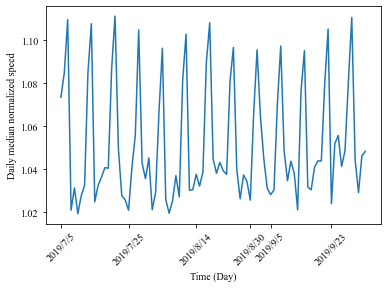

In [55]:
#### Neutral resilience

start_datetime = pd.Timestamp('2019-07-05 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 7, 1, 0, 0))
end_datetime = pd.Timestamp('2019-10-04 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 10, 1, 0, 0))
kkk = np.where(phase_neutral == True)[0][0]
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id_list_sel[kkk]]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] >= start_datetime]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] <= end_datetime]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)

t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
daily_med_speed_norm = []
miami_daily_order = miami_daily_order_o.copy()

for i in range (91): 
    miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
    miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
    miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'speed_norm']], how = 'left', on = 'Time')
    t1 = t2
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
    # Fill the NaN values in column 'A' with corresponding values from the other array
    day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6    
    nan_locs = miami_daily_order['speed_norm'].isna()
    miami_daily_order.loc[nan_locs, 'speed_norm'] = miami_traffic_zone_id_speed_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
    daily_med_speed_norm.append(np.nanmedian(miami_daily_order['speed_norm']))

print(resilience_zone_id_attr_new['speed_resilience'].iloc[kkk])
plt.plot(daily_med_speed_norm)
plt.xlabel('Time (Day)')
plt.xticks(ticks = [0, 20, 40, 56, 62, 80], labels=['2019/7/5', '2019/7/25', '2019/8/14', '2019/8/30', '2019/9/5', '2019/9/23'])
plt.xticks(rotation = 45)
plt.ylabel('Daily median normalized speed')

In [56]:
daily_med_speed_norm = np.array(daily_med_speed_norm)
disrupt_speed_norm = np.nanmean(daily_med_speed_norm[disrupt_index_list])
norm_speed_norm = np.nanmean(daily_med_speed_norm[norm_index_list])
disrupt_speed_norm - norm_speed_norm

-0.0008851203557955767

-0.025361832223979


Text(0, 0.5, 'Daily median normalized speed')

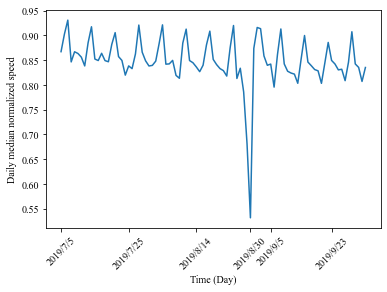

In [57]:
#### Negative resilience

start_datetime = pd.Timestamp('2019-07-05 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 7, 1, 0, 0))
end_datetime = pd.Timestamp('2019-10-04 00:00:00', tz='UTC') # pd.to_datetime(datetime(2019, 10, 1, 0, 0))
kkk = np.where(phase_negative == True)[0][97]
miami_traffic_zone_id = miami_traffic_zone[miami_traffic_zone['zone_id'] == zone_id_list_sel[kkk]]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] >= start_datetime]
miami_traffic_zone_id = miami_traffic_zone_id[miami_traffic_zone_id['Time'] <= end_datetime]
miami_traffic_zone_id = miami_traffic_zone_id.reset_index(drop=True)

t1 = start_datetime
t2 = t1 + pd.DateOffset(days=1)
daily_med_speed_norm = []
miami_daily_order = miami_daily_order_o.copy()

for i in range (91): 
    miami_traffic_zone_id_daily = miami_traffic_zone_id.loc[miami_traffic_zone_id['Time'] >= t1]
    miami_traffic_zone_id_daily = miami_traffic_zone_id_daily.loc[miami_traffic_zone_id['Time'] <= t2]
    miami_daily_order = miami_daily_order[['Time', 'zone_id']].merge(miami_traffic_zone_id_daily[['Time', 'speed_norm']], how = 'left', on = 'Time')
    t1 = t2
    t2 = t1 + pd.DateOffset(days=1)
    miami_daily_order['Time'] = miami_daily_order['Time'] + pd.DateOffset(days=1)
    # Fill the NaN values in column 'A' with corresponding values from the other array
    day_of_week = (i + 5) - int((i + 5) / 7) * 7 # 0-6    
    nan_locs = miami_daily_order['speed_norm'].isna()
    miami_daily_order.loc[nan_locs, 'speed_norm'] = miami_traffic_zone_id_speed_mean[kkk][list(np.arange(day_of_week * 288, (day_of_week + 1) * 288))][nan_locs]
    daily_med_speed_norm.append(np.nanmedian(miami_daily_order['speed_norm']))

print(resilience_zone_id_attr_new['speed_resilience'].iloc[kkk])
plt.plot(daily_med_speed_norm)
plt.xlabel('Time (Day)')
plt.xticks(ticks = [0, 20, 40, 56, 62, 80], labels=['2019/7/5', '2019/7/25', '2019/8/14', '2019/8/30', '2019/9/5', '2019/9/23'])
plt.xticks(rotation = 45)
plt.ylabel('Daily median normalized speed')

In [58]:
daily_med_speed_norm = np.array(daily_med_speed_norm)
disrupt_speed_norm = np.nanmean(daily_med_speed_norm[disrupt_index_list])
norm_speed_norm = np.nanmean(daily_med_speed_norm[norm_index_list])
disrupt_speed_norm - norm_speed_norm

-0.02536183222397903

##### XY phases framework for volume resilience and speed resilience

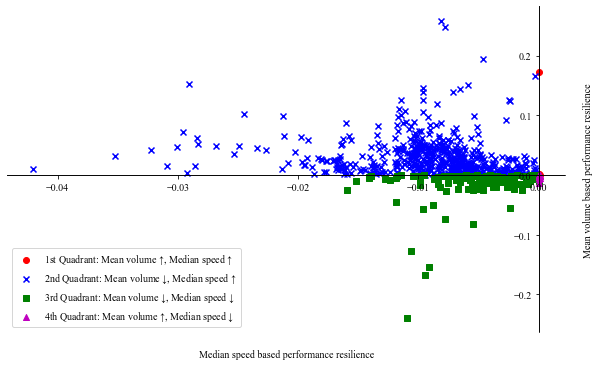

In [59]:
XX = resilience_zone_id_attr['volume_resilience'].values
YY = resilience_zone_id_attr['speed_resilience'].values

# Define conditions for four phases
phase1 = (XX >= 0) & (YY >= 0)
phase2 = (XX < 0) & (YY >= 0)
phase3 = (XX < 0) & (YY < 0)
phase4 = (XX >= 0) & (YY < 0)

# Plotting
plt.figure(figsize=(10, 6))

up_arrow = u'$\u2191$'  # Unicode for up arrow symbol
down_arrow = u'$\u2193$'  # Unicode for down arrow symbol

# Plot each phase with different colors and markers
plt.scatter(XX[phase1], YY[phase1], c='r', marker='o', label='1st Quadrant: Mean volume (up), Median speed (up)')
plt.scatter(XX[phase2], YY[phase2], c='b', marker='x', label='2nd Quadrant: Mean volume (down), Median speed (up)')
plt.scatter(XX[phase3], YY[phase3], c='g', marker='s', label='3rd Quadrant: Mean volume (down), Median speed (down)')
plt.scatter(XX[phase4], YY[phase4], c='m', marker='^', label='4th Quadrant: Mean volume (up), Median speed (down)')

# Add central axes
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)

# Remove the top and right spines (boundary box)
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Set ticks position
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_coords(1.05, -0.05)  # Adjust the coordinates as needed
plt.ylabel('Mean volume based performance resilience', labelpad=20)
ax.xaxis.set_label_coords(1.05, -0.05)  # Adjust the coordinates as needed
plt.xlabel('Median speed based performance resilience', labelpad=20)  # labelpad to add some space
# plt.legend()

plt.legend([f'1st Quadrant: Mean volume {up_arrow}, Median speed {up_arrow}', 
            f'2nd Quadrant: Mean volume {down_arrow}, Median speed {up_arrow}',
            f'3rd Quadrant: Mean volume {down_arrow}, Median speed {down_arrow}',
            f'4th Quadrant: Mean volume {up_arrow}, Median speed {down_arrow}'])

plt.show()

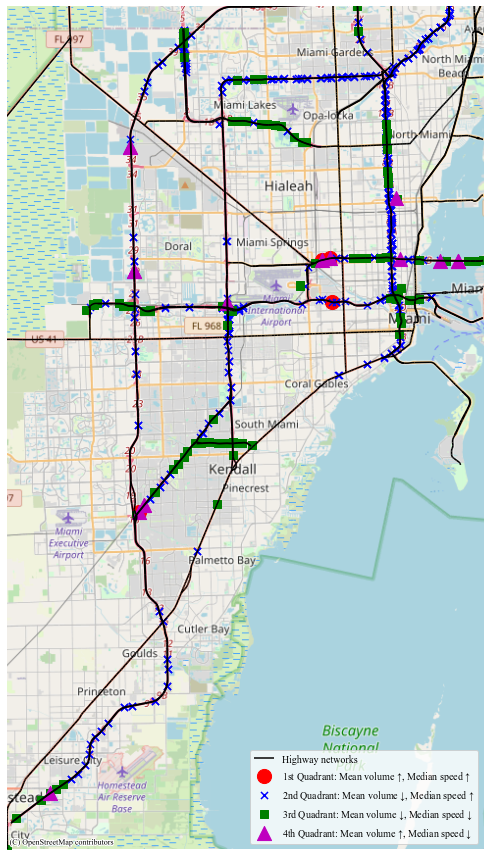

In [60]:
XX = resilience_zone_id_attr['volume_resilience'].values
YY = resilience_zone_id_attr['speed_resilience'].values

# Define conditions for four phases
phase1 = (XX >= 0) & (YY >= 0)
phase2 = (XX < 0) & (YY >= 0)
phase3 = (XX < 0) & (YY < 0)
phase4 = (XX >= 0) & (YY < 0)

import contextily as ctx
# from matplotlib.colors import LogNorm

miami_highway_network_new = gpd.read_file('Data/Highway.geojson').to_crs(epsg=3857)

resilience_zone_id_attr_new = gpd.GeoDataFrame(resilience_zone_id_attr)
resilience_zone_id_attr_new['geometry'] = resilience_zone_id_attr_new['geometry'].to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
divider = make_axes_locatable(ax)

up_arrow = u'$\u2191$'  # Unicode for up arrow symbol
down_arrow = u'$\u2193$'  # Unicode for down arrow symbol

base1 = miami_highway_network_new.plot(ax=ax, edgecolor='black', facecolor='none')

# Plot each phase with different colors and markers

resilience_zone_id_attr_new.loc[phase1].plot(ax = base1, c='r', marker='o', markersize = 200, label='Phase 1: Mean volume (up), Median speed (up)')
resilience_zone_id_attr_new.loc[phase2].plot(ax = base1, c='b', marker='x', markersize = 50, label='Phase 2: Mean volume (down), Median speed (up)')
resilience_zone_id_attr_new.loc[phase3].plot(ax = base1, c='g', marker='s', markersize = 50, label='Phase 3: Mean volume (down), Median speed (down)')
resilience_zone_id_attr_new.loc[phase4].plot(ax = base1, c='m', marker='^', markersize = 200, label='Phase 4: Mean volume (up), Median speed (down)')


plt.legend(['Highway networks',
            f'1st Quadrant: Mean volume {up_arrow}, Median speed {up_arrow}', 
            f'2nd Quadrant: Mean volume {down_arrow}, Median speed {up_arrow}',
            f'3rd Quadrant: Mean volume {down_arrow}, Median speed {down_arrow}',
            f'4th Quadrant: Mean volume {up_arrow}, Median speed {down_arrow}'])

multi_line = resilience_zone_id_attr_new.geometry.unary_union

# Calculate combined bounding box
xmin, ymin, xmax, ymax = multi_line.bounds
bbox = [xmin, ymin, xmax, ymax]
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [61]:
print(np.sum(phase1), np.sum(phase2), np.sum(phase3), np.sum(phase4))

4 533 114 16
